In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201211_121249.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201211_121703.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201211_121541.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201114_102932.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201114_102159.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201211_121524.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_20201211_121655.jpg
/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/IMG_2020

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import os
import shutil
from os import path
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras

In [5]:
train_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
test_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'
validation_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'

In [6]:
test_def = pd.DataFrame(os.listdir(train_add + '/Defective'))
test_ndef = pd.DataFrame(os.listdir(train_add + '/Non defective'))
val_def = pd.DataFrame(os.listdir(test_add + '/Defective'))
val_ndef = pd.DataFrame(os.listdir(test_add + '/Non defective'))
train_def = pd.DataFrame(os.listdir(validation_add + '/Defective'))
train_ndef = pd.DataFrame(os.listdir(validation_add + '/Non defective'))

In [7]:
print("Size of training dataset: ", len(train_def)+len(train_ndef))
print("Size of test dataset: ", len(test_def)+len(test_ndef))
print("Size of validation dataset: ", len(val_def)+len(val_ndef))

Size of training dataset:  62
Size of test dataset:  300
Size of validation dataset:  22


In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 62 files belonging to 2 classes.


In [9]:
# Getting the class names in order
class_names = train_ds.class_names
print(class_names)

['Defective', 'Non defective']


In [10]:
# Normalize function
def normalize(image, label):
  image = tf.cast(image/256, tf.float32)
  return image, label

train_ds = train_ds.map(normalize)

**Sample Images**

Defective data sample



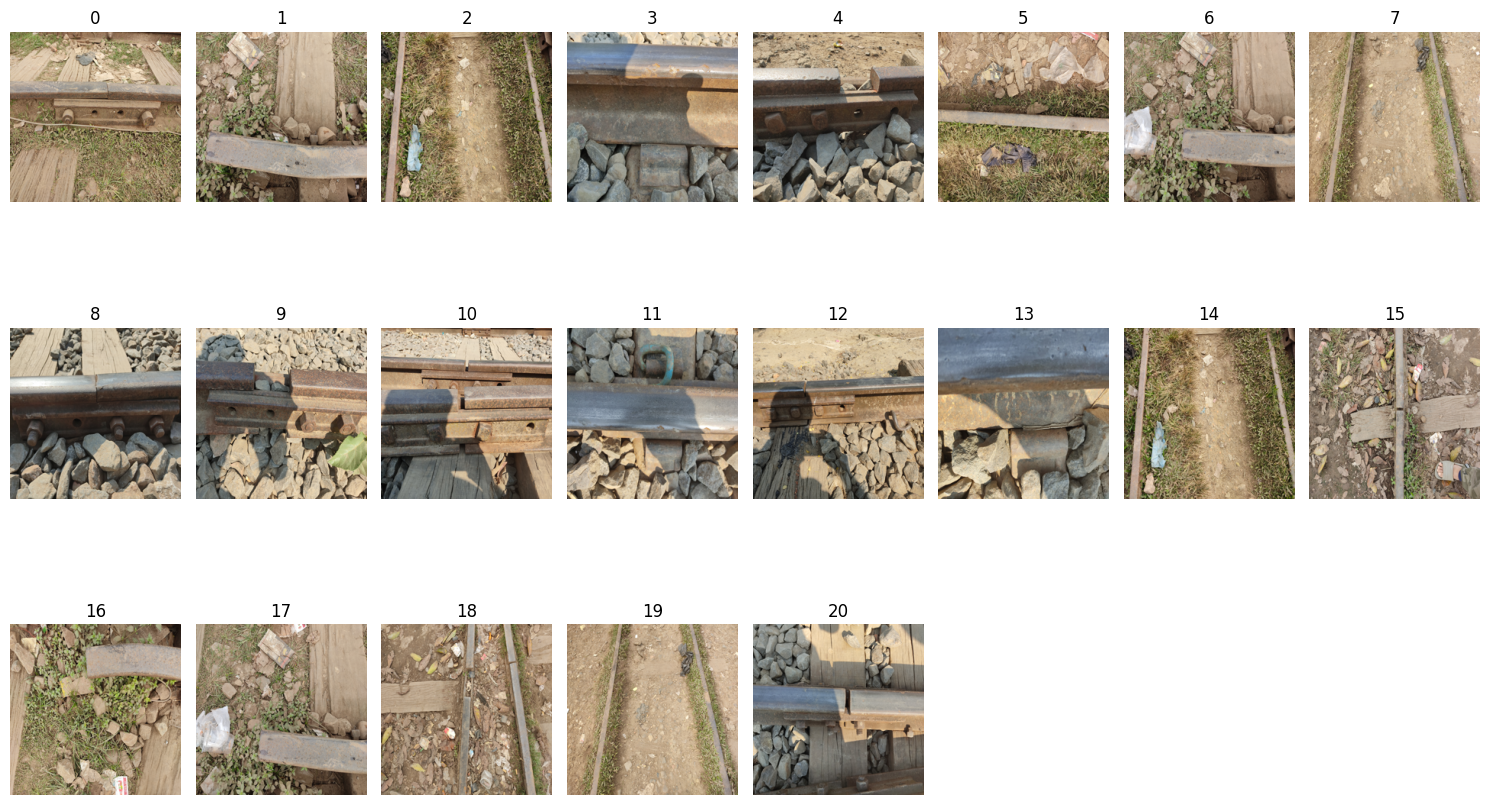

In [12]:
print("Defective data sample\n")
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(train_def[0]):
    if idx==21:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open('/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective/'+image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

Non defective data sample



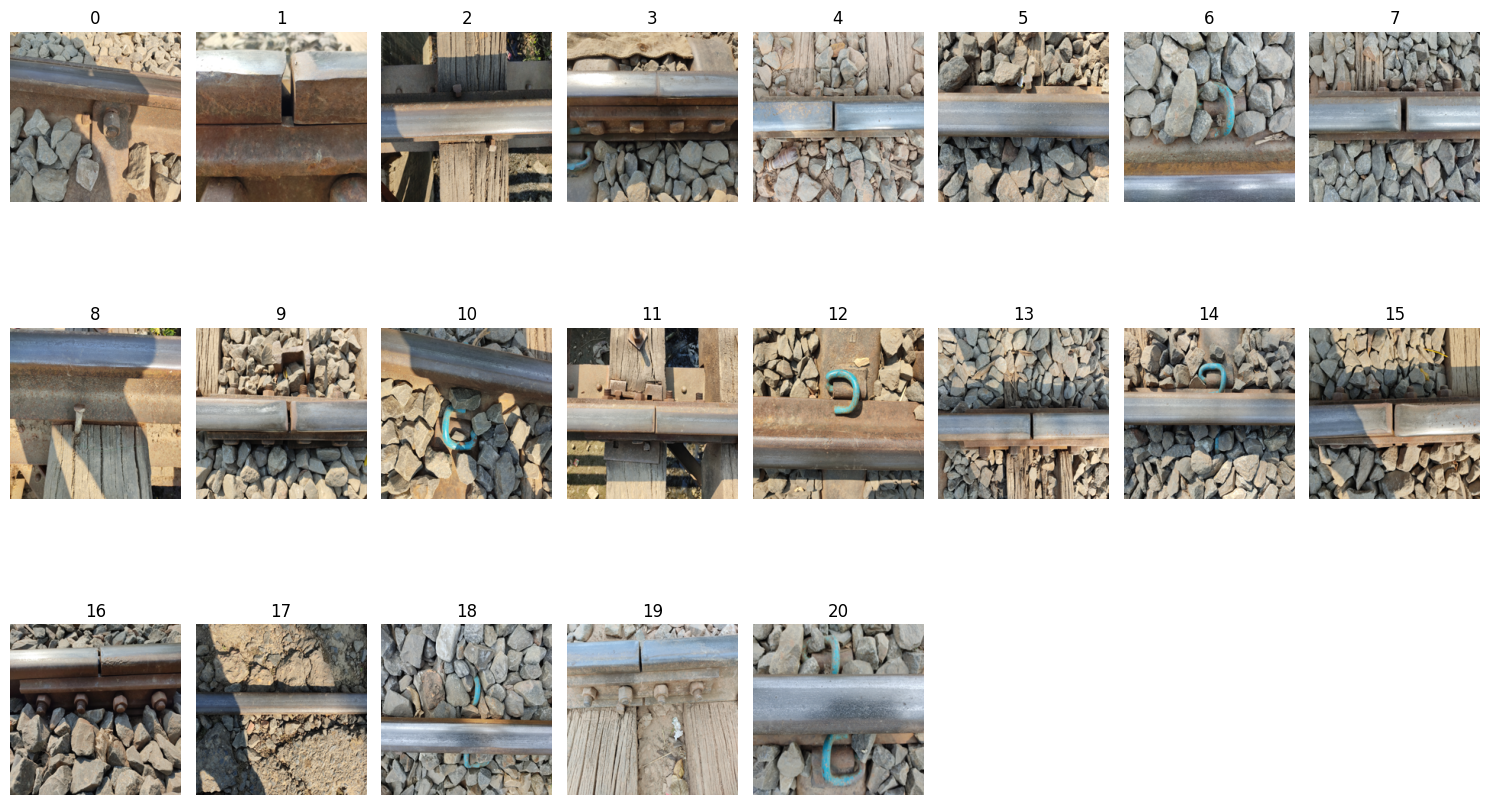

In [13]:
print("Non defective data sample\n")
plt.figure(figsize = (15,12))
for idx,image_path in enumerate(train_ndef[0]):
    if idx==21:
        break
    plt.subplot(4,8,idx+1)
    img = Image.open('/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Non defective/'+image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)
plt.tight_layout()
plt.show()

# **Performing Image Augmentation**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# Data Generator
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

**Trial Run**

In [16]:
# Checking the datagen augmentation
image_paths = ['/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test/Defective/IMG_20201114_100209.jpg',
               '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test/Defective/IMG_20201211_121713.jpg']
output_dir = 'checkAugmentation'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num_images = 2 # Generating 2 images from each image in the image_paths directory
gen_images=0
for image_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(image_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate augmented images and save them
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpg'):
            gen_images += 1
            if gen_images >= num_images:
                break

        if gen_images >= num_images:
            break

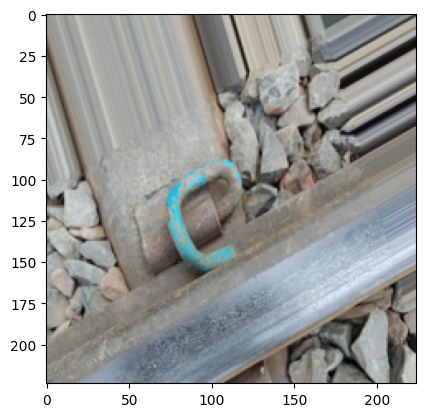

In [17]:
img = Image.open('/kaggle/working/checkAugmentation/aug_0_9990.jpg')
img = img.resize((224,224))
plt.imshow(img)

**Actual Augmentation**

In [18]:
input_dir = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Train' 
output_dir = 'augmented_dataset' 

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Subfolders in the input directory
subfolders = [f.name for f in os.scandir(input_dir) if f.is_dir()]

In [19]:
# Function to save augmented images
def save_augmented_images(class_name, num_images):
    input_subdir = os.path.join(input_dir, class_name)

    image_paths = [os.path.join(input_subdir, img) for img in os.listdir(input_subdir) if img.endswith(('.jpg', '.jpeg', '.png'))]

    total_images = len(image_paths)
    generated_images = 0
    to_generate = int(num_images/len(image_paths)) + 1 # number of images to generate from each image in the image_paths
    add = to_generate
    for image_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(image_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate augmented images and save them
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpg'):
            generated_images += 1
            if generated_images > to_generate:
                to_generate+=add
                break

        if generated_images > num_images:
            break
        print("Number of Generated images: ", generated_images)

In [20]:
time.time()

1723357442.8499684

In [21]:
num_augmented_images_per_class = 250

# Generate and save augmented images for each class
start_time = time.time()

for subfolder in subfolders:
    save_augmented_images(subfolder, num_augmented_images_per_class)

end_time = time.time()

print("Augmented images generated and saved successfully.")
print("Total time elapsed: ", (end_time - start_time)/60, " minutes")

Number of Generated images:  3
Number of Generated images:  5
Number of Generated images:  7
Number of Generated images:  9
Number of Generated images:  11
Number of Generated images:  13
Number of Generated images:  15
Number of Generated images:  17
Number of Generated images:  19
Number of Generated images:  21
Number of Generated images:  23
Number of Generated images:  25
Number of Generated images:  27
Number of Generated images:  29
Number of Generated images:  31
Number of Generated images:  33
Number of Generated images:  35
Number of Generated images:  37
Number of Generated images:  39
Number of Generated images:  41
Number of Generated images:  43
Number of Generated images:  45
Number of Generated images:  47
Number of Generated images:  49
Number of Generated images:  51
Number of Generated images:  53
Number of Generated images:  55
Number of Generated images:  57
Number of Generated images:  59
Number of Generated images:  61
Number of Generated images:  63
Number of Ge

In [22]:
# zip the augmented dataset
import shutil

shutil.make_archive('augmented_dataset', 'zip', 'augmented_dataset')

'/kaggle/working/augmented_dataset.zip'

In [23]:
# Generating link to download the augmented dataset in local machine
from IPython.display import FileLink

FileLink(r'augmented_dataset.zip')

/kaggle/working/augmented_dataset.zip

This notebook is used to get familiar with the dataset and then generate around 500 augmented images from the training dataset containing only 62 images.